In [74]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.size'] = 12

plt.style.use('tableau-colorblind10')

In [75]:
GPU_TDP = 250 # Watt
CPU_TDP = 85 # Watt
time = 1.6679636111111111 # hours
GPU_utilisation =  98.41828958509737 #percentage
CPU_utilisation = 1 #assumed

In [76]:
dictionary = {'method':[],'energy':[]}

In [77]:
#mlco2 energy used = 0.4169909027777778 kWh
mlco2= (time * GPU_TDP) / 1000
dictionary['method'].append('time * GPU TDP')
dictionary['energy'].append(mlco2)

In [78]:
ai_and_compute = (time * GPU_TDP * 1/3) / 1000
dictionary['method'].append('time * GPU TDP * 1/3 util')
dictionary['energy'].append(ai_and_compute)

In [79]:
actual_util = (time * ( GPU_TDP * GPU_utilisation/100 +  CPU_TDP * CPU_utilisation)) / 1000
dictionary['method'].append('time * (GPU + CPU) * real_util')
dictionary['energy'].append(actual_util)

In [80]:
# empirical values
# nvidia-smi GPU energy consumption = 0.43921391388888886 kWh
# GPU + CPU energy consumption = 0.5627291196798899 kWh
# power monitor reading = 0.6127022608333333 kWh
power_monitor_reading = 0.6127022608333333
dictionary['method'].append('empirical')
dictionary['energy'].append(power_monitor_reading)

In [81]:
df= pd.DataFrame(dictionary)

In [82]:
df.head()

,method,energy
0,time * GPU TDP,0.416991
1,time * GPU TDP * 1/3 util,0.138997
2,time * (GPU + CPU) * real_util,0.552172
3,empirical,0.612702


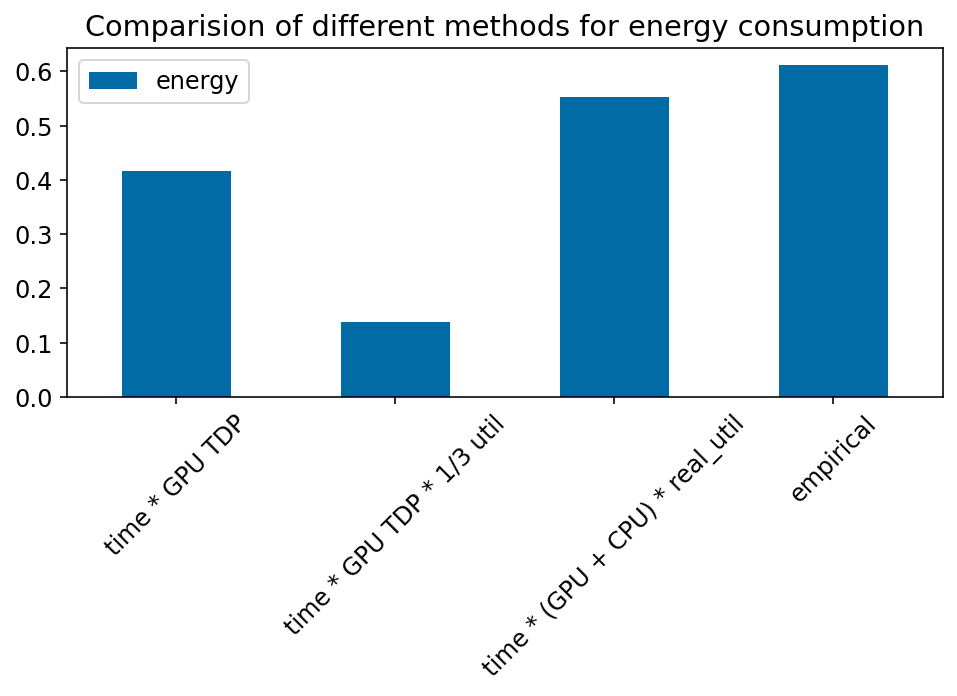

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
df.plot.bar(x='method', y='energy', rot=45,title="Comparision of different methods for energy consumption",ax=ax)
ax.set_xlabel("")
plt.tight_layout()
ax.figure.savefig("viz/compareEnergy.png",dpi=300)

## See how the values scale with time using finetuning training 

In [84]:
df_finetune = pd.read_csv("results/model_pm_energy_finetune.csv")

In [86]:
df_finetune['power'].count()

51

In [87]:
df_finetune['time * GPU TDP'] = df_finetune['time_in_hour'] * GPU_TDP / 1000
df_finetune['time * GPU TDP * 1/3 util'] = (df_finetune['time_in_hour'] * GPU_TDP * 1/3) / 1000
df_finetune['time * (GPU + CPU) * real_util'] = ((df_finetune['time_in_hour'] *  GPU_TDP * GPU_utilisation/100 )
  +  (df_finetune['cpu_time']/3600 * CPU_TDP * CPU_utilisation)) / 1000

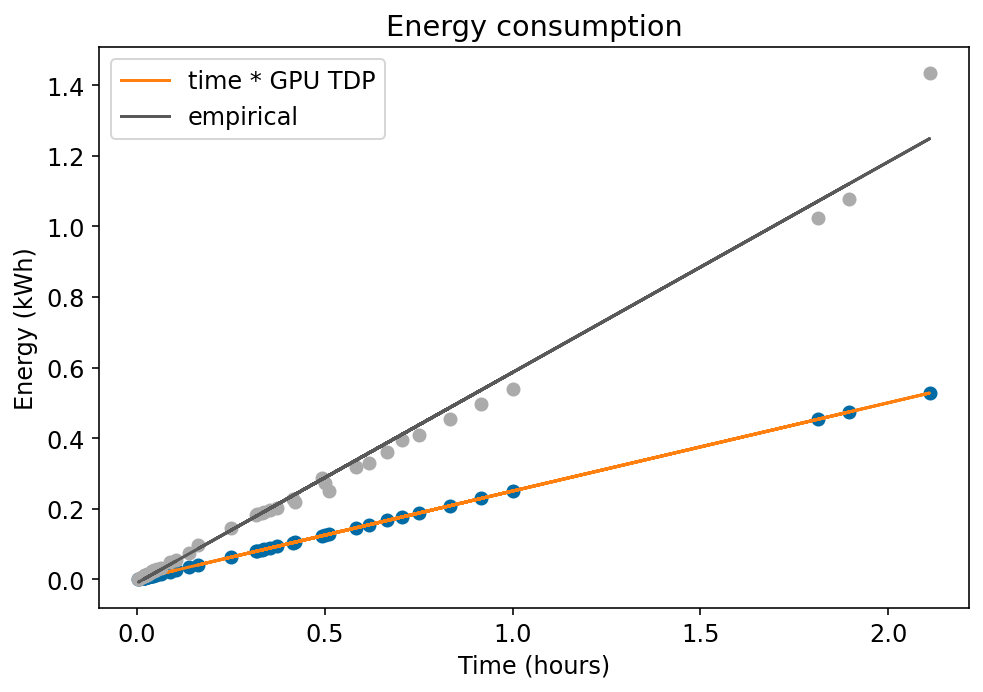

In [88]:
from scipy import stats
x = df_finetune['time_in_hour']
y1 = df_finetune['time * GPU TDP']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * GPU TDP')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/mlco2ModelVsPMPower.png',dpi=300)

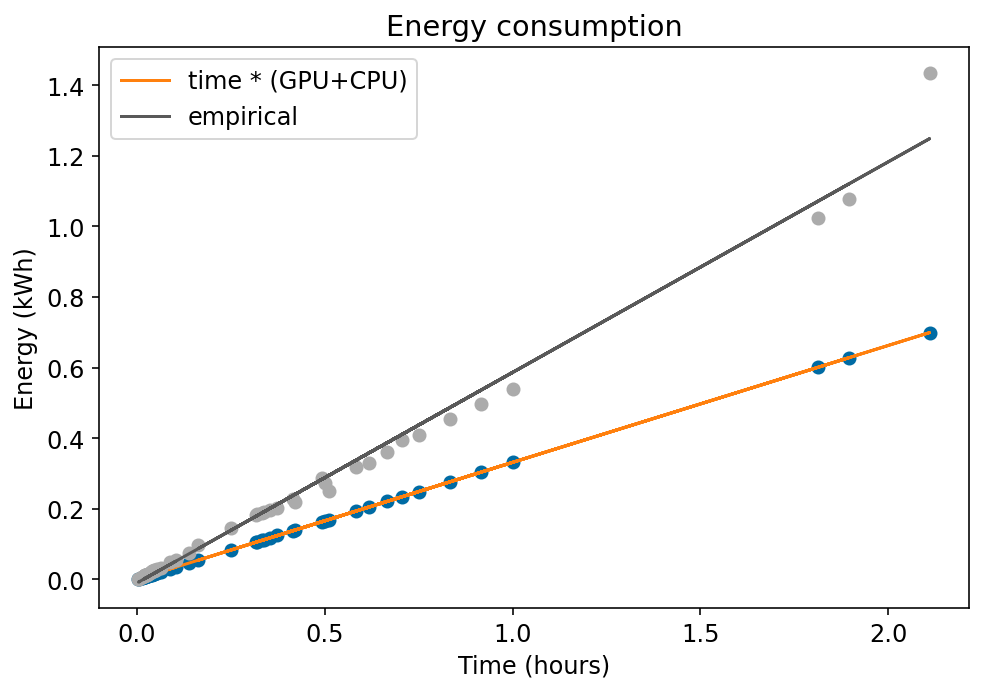

In [94]:

x = df_finetune['time_in_hour']
y1 = df_finetune['time * (GPU + CPU) * real_util']
y2 = df_finetune['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()
plt.savefig('viz/CPU_GPU_ModelVsPMPower.png',dpi=300)

In [90]:
stat, p = stats.normaltest(x)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=35.934, p=0.000
Sample does not look Gaussian (reject H0)


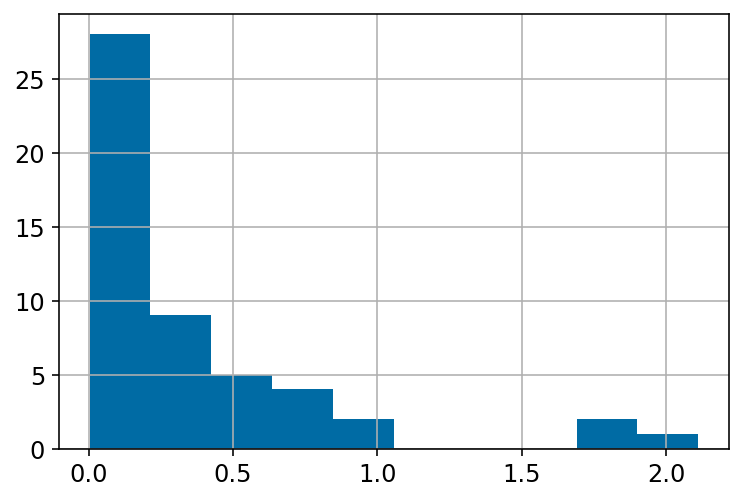

In [91]:
x.hist()

In [92]:
df_64 = df_finetune.loc[(df_finetune.batchsize == 64) & (df_finetune.max_seq_len == 128)]
df_64 = df_64.sort_values('dataset_size')

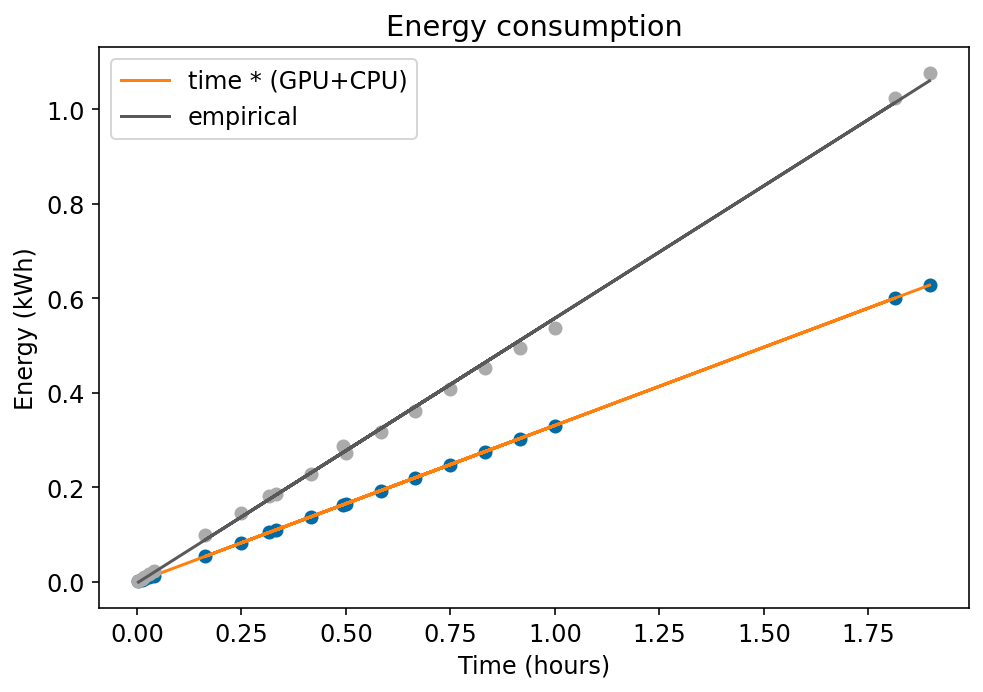

In [95]:
x = df_64['time_in_hour']
y1 = df_64['time * (GPU + CPU) * real_util']
y2 = df_64['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y1)
plt.plot(x, y1,'o')
plt.plot(x, slope * x + intercept, label='time * (GPU+CPU)')
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y2)
plt.plot(x, y2,'o')
plt.plot(x, slope * x + intercept, label='empirical')
plt.xlabel("Time (hours)")
plt.ylabel("Energy (kWh)")
plt.title("Energy consumption")
plt.legend()
plt.tight_layout()


1.6926045247342651 -0.002546278553099357 0.9994948419017725 2.030490639978686e-28 0.01268564318477148


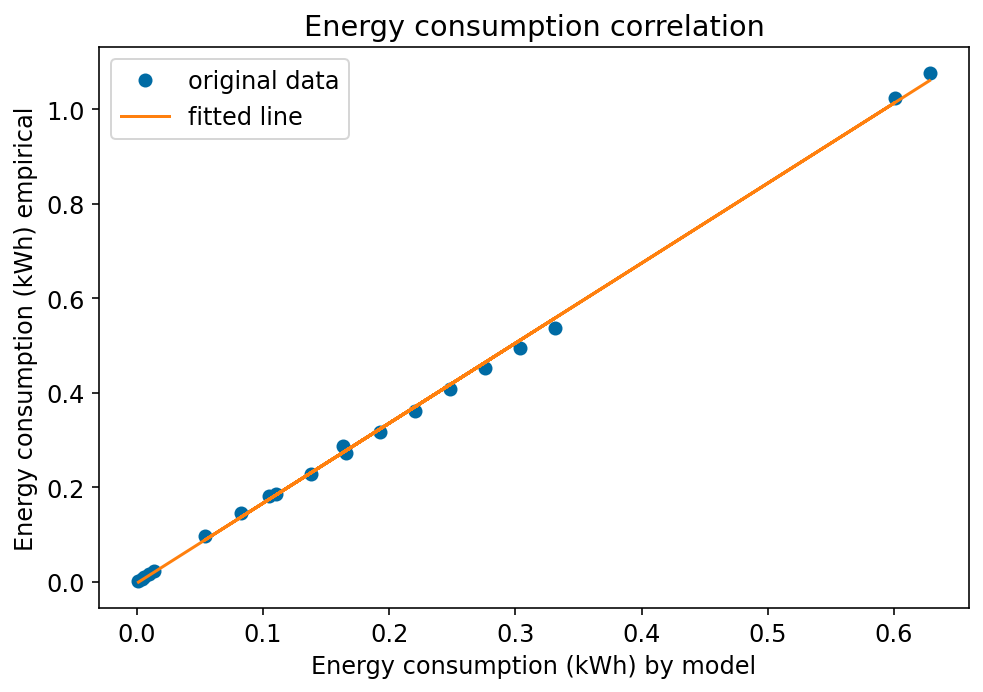

In [98]:
x = df_64['time * (GPU + CPU) * real_util']
y = df_64['pm_energy_consumption']
plt.figure(figsize=(7,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print(slope, intercept, r_value, p_value, std_err)
plt.plot(x, y,'o',label='original data')
plt.plot(x, slope * x + intercept, label='fitted line')

plt.xlabel("Energy consumption (kWh) by model")
plt.ylabel("Energy consumption (kWh) empirical")
plt.title("Energy consumption correlation")
plt.legend()
plt.tight_layout()
plt.savefig('viz/Corr_CPU_GPU_ModelVsPMPower.png',dpi=300)